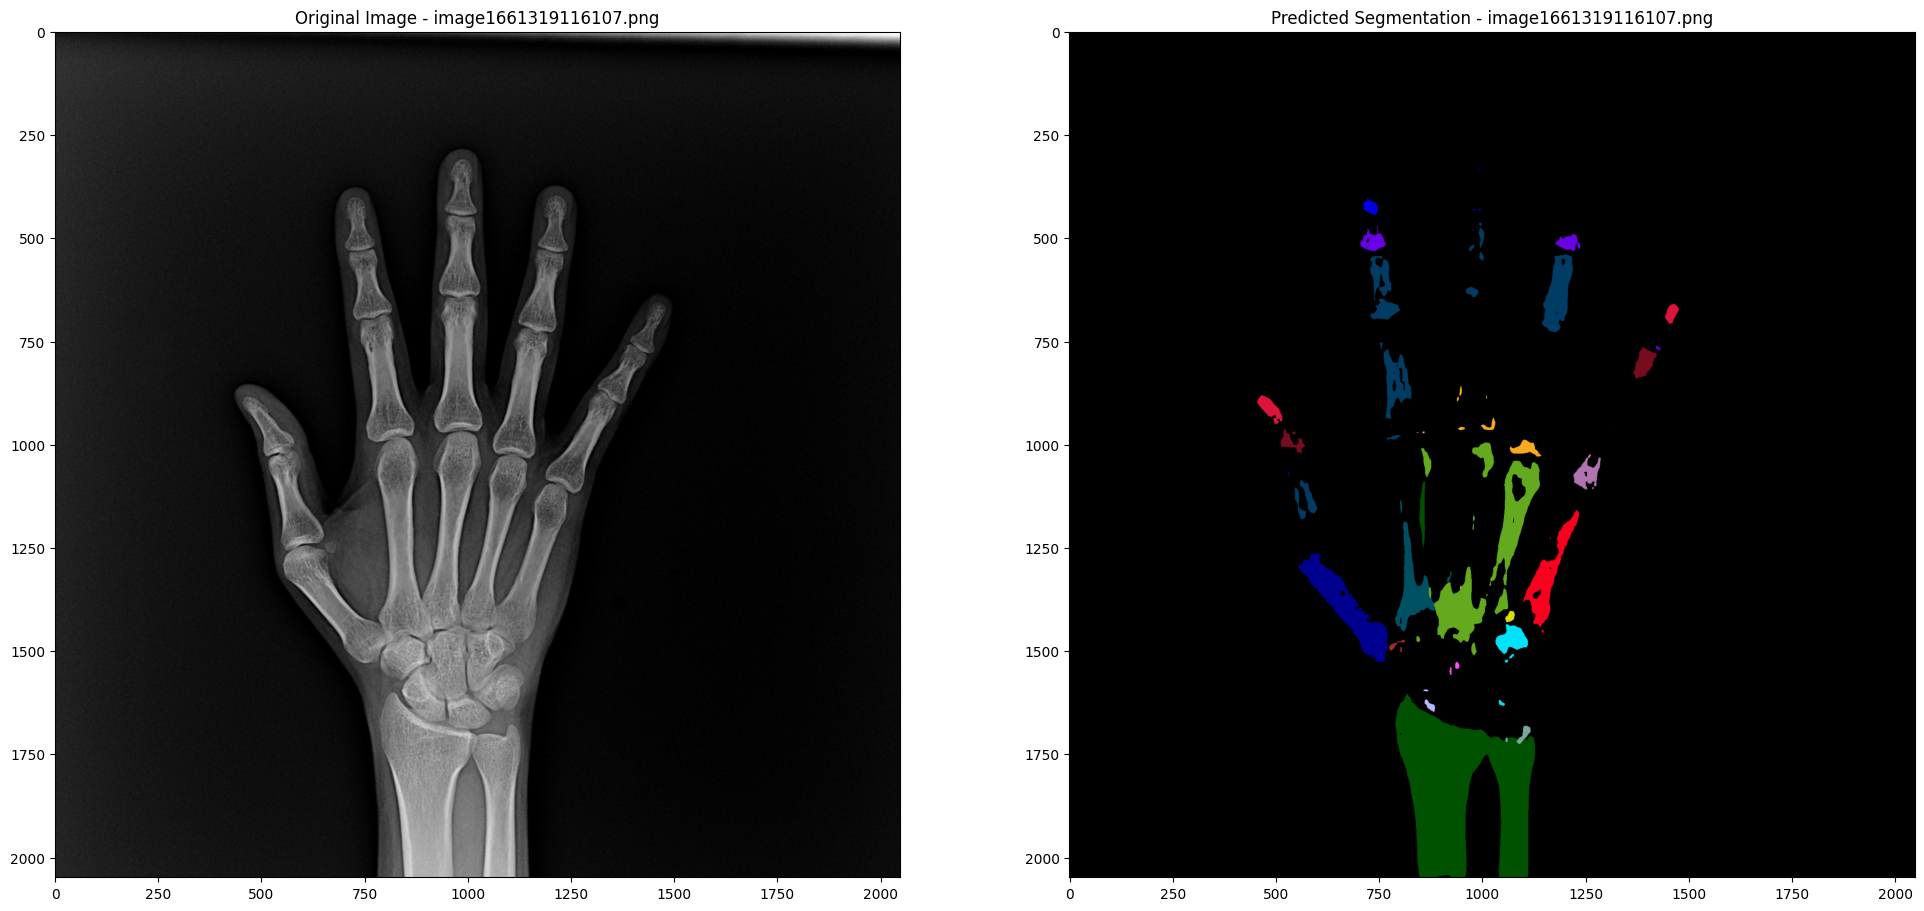

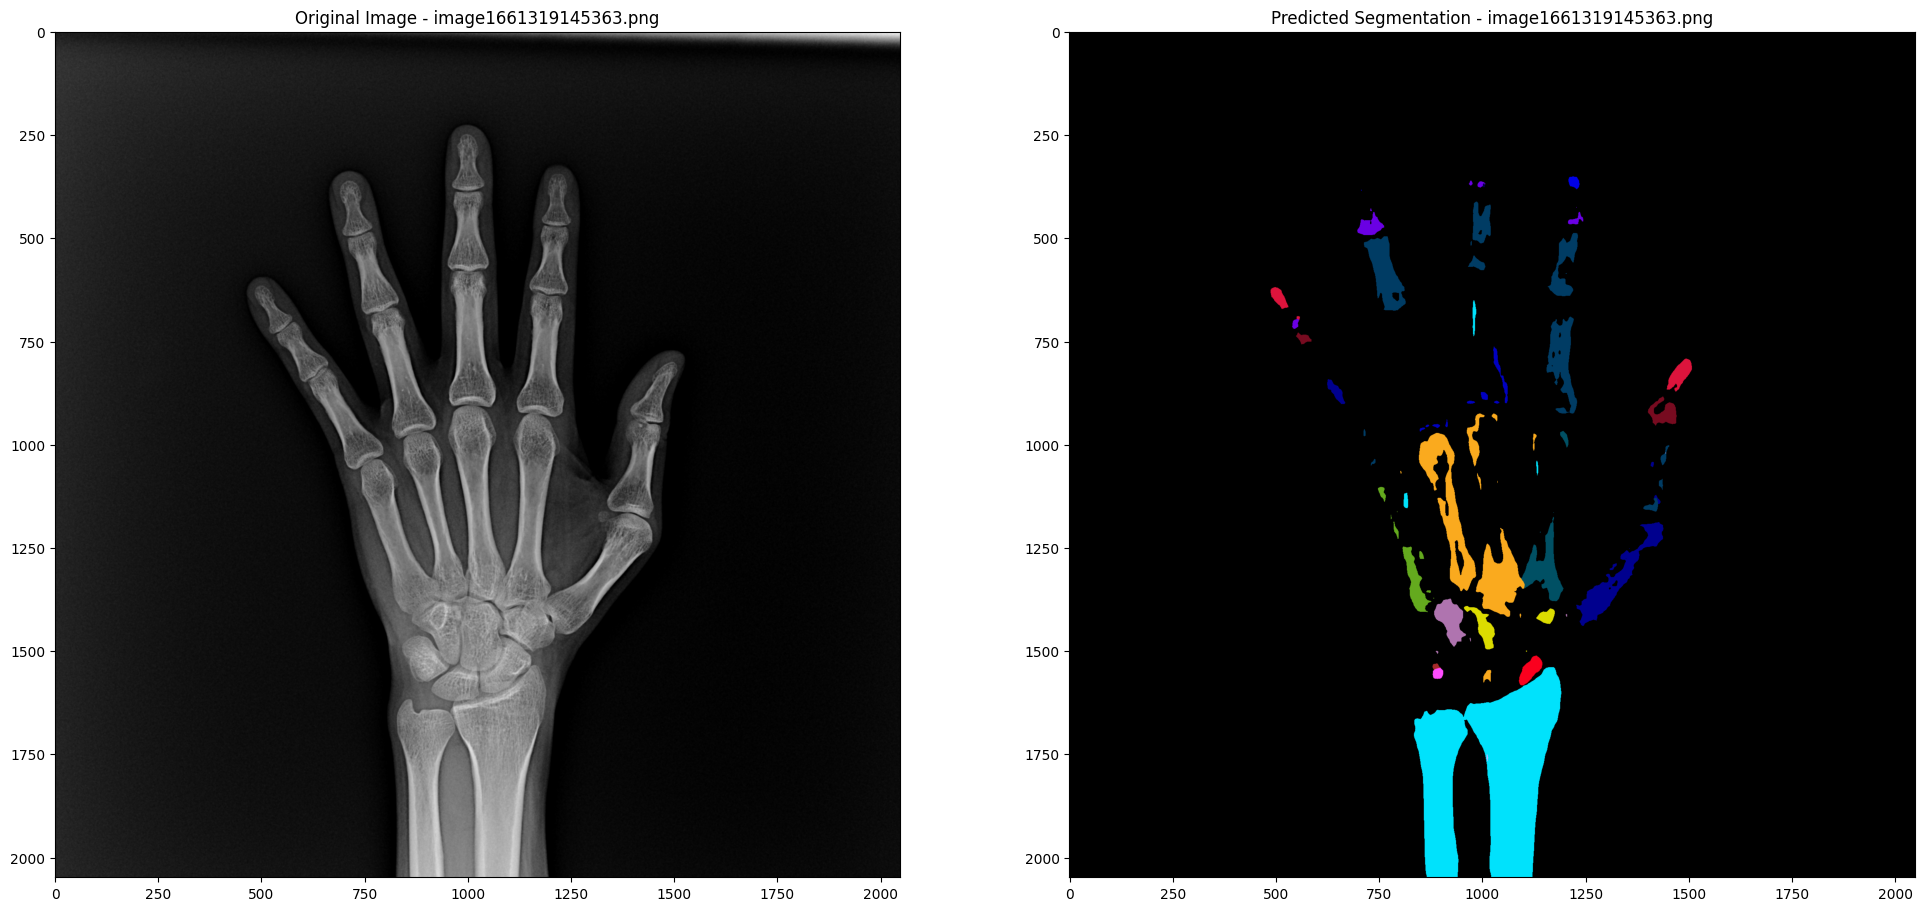

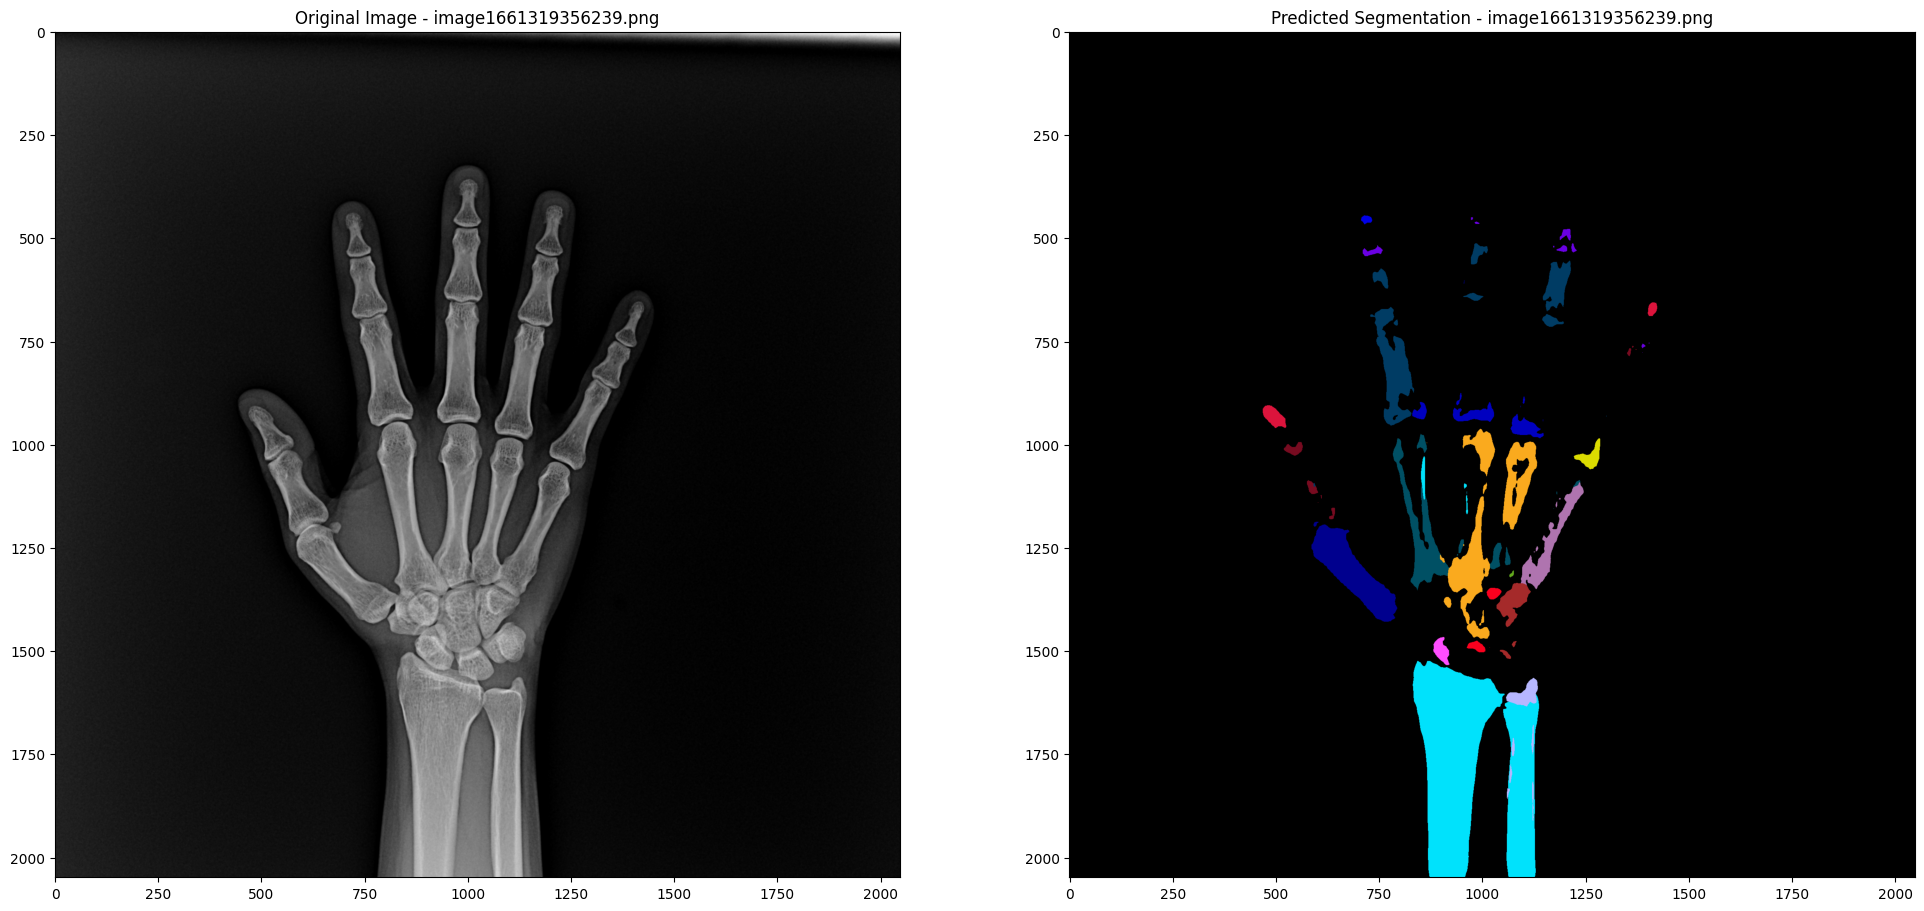

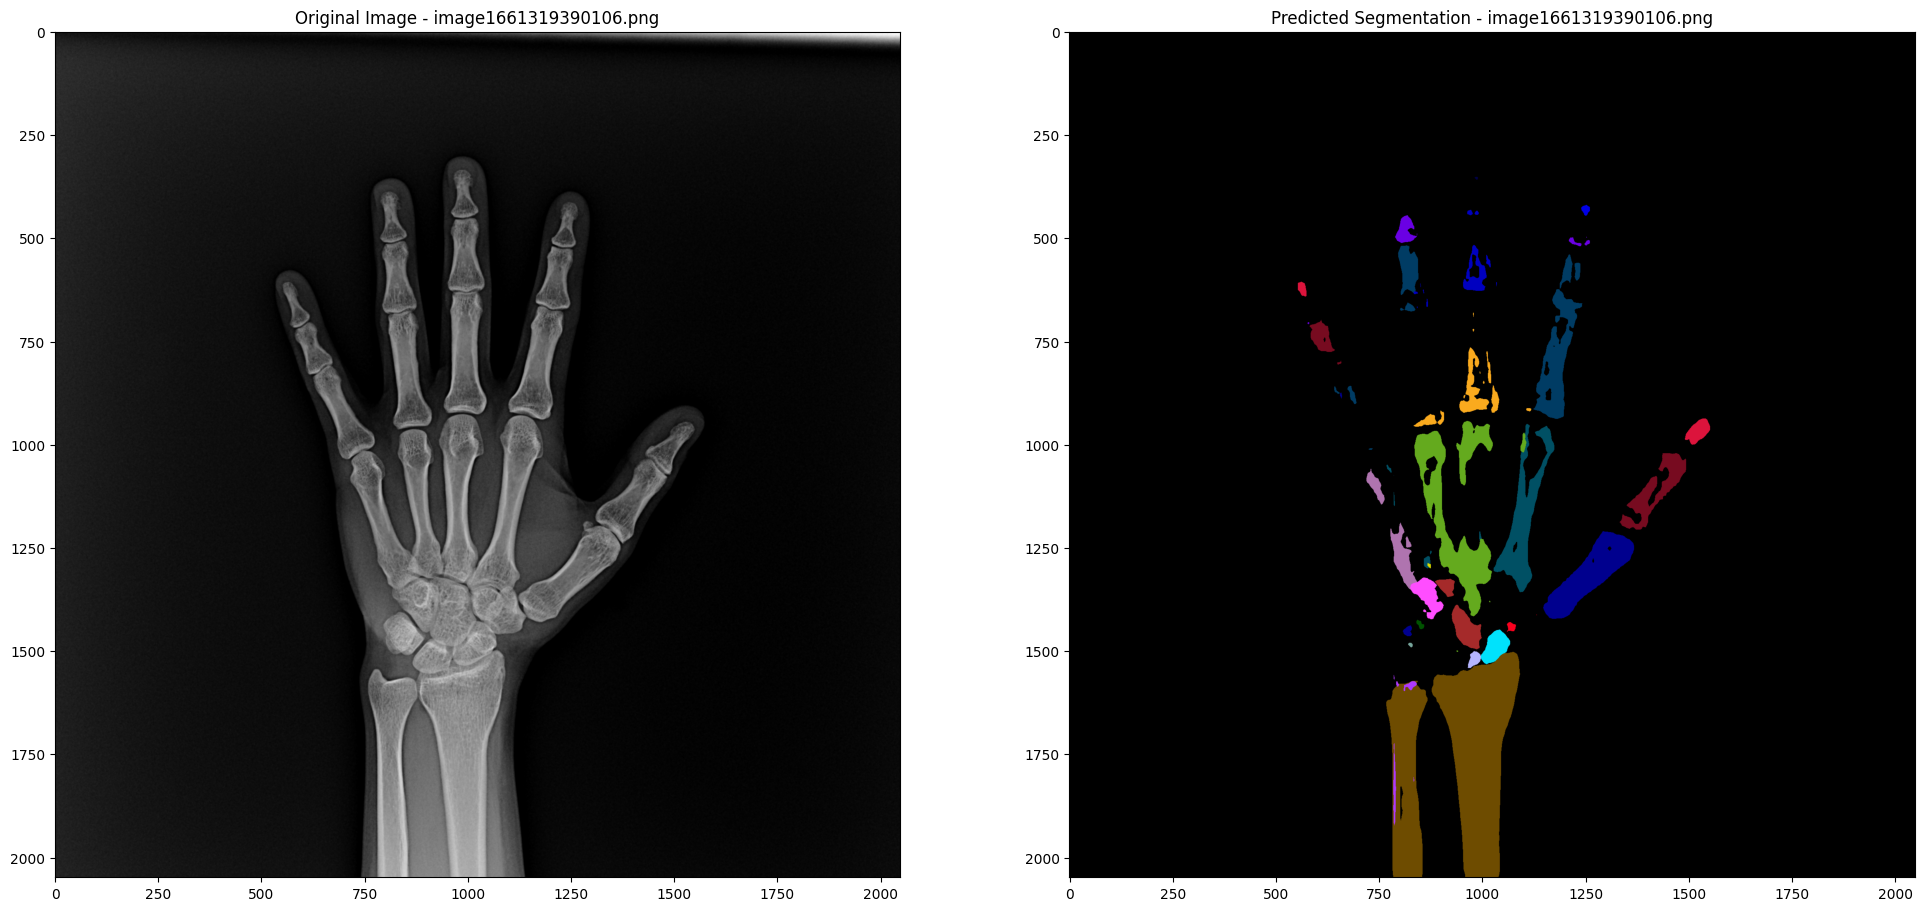

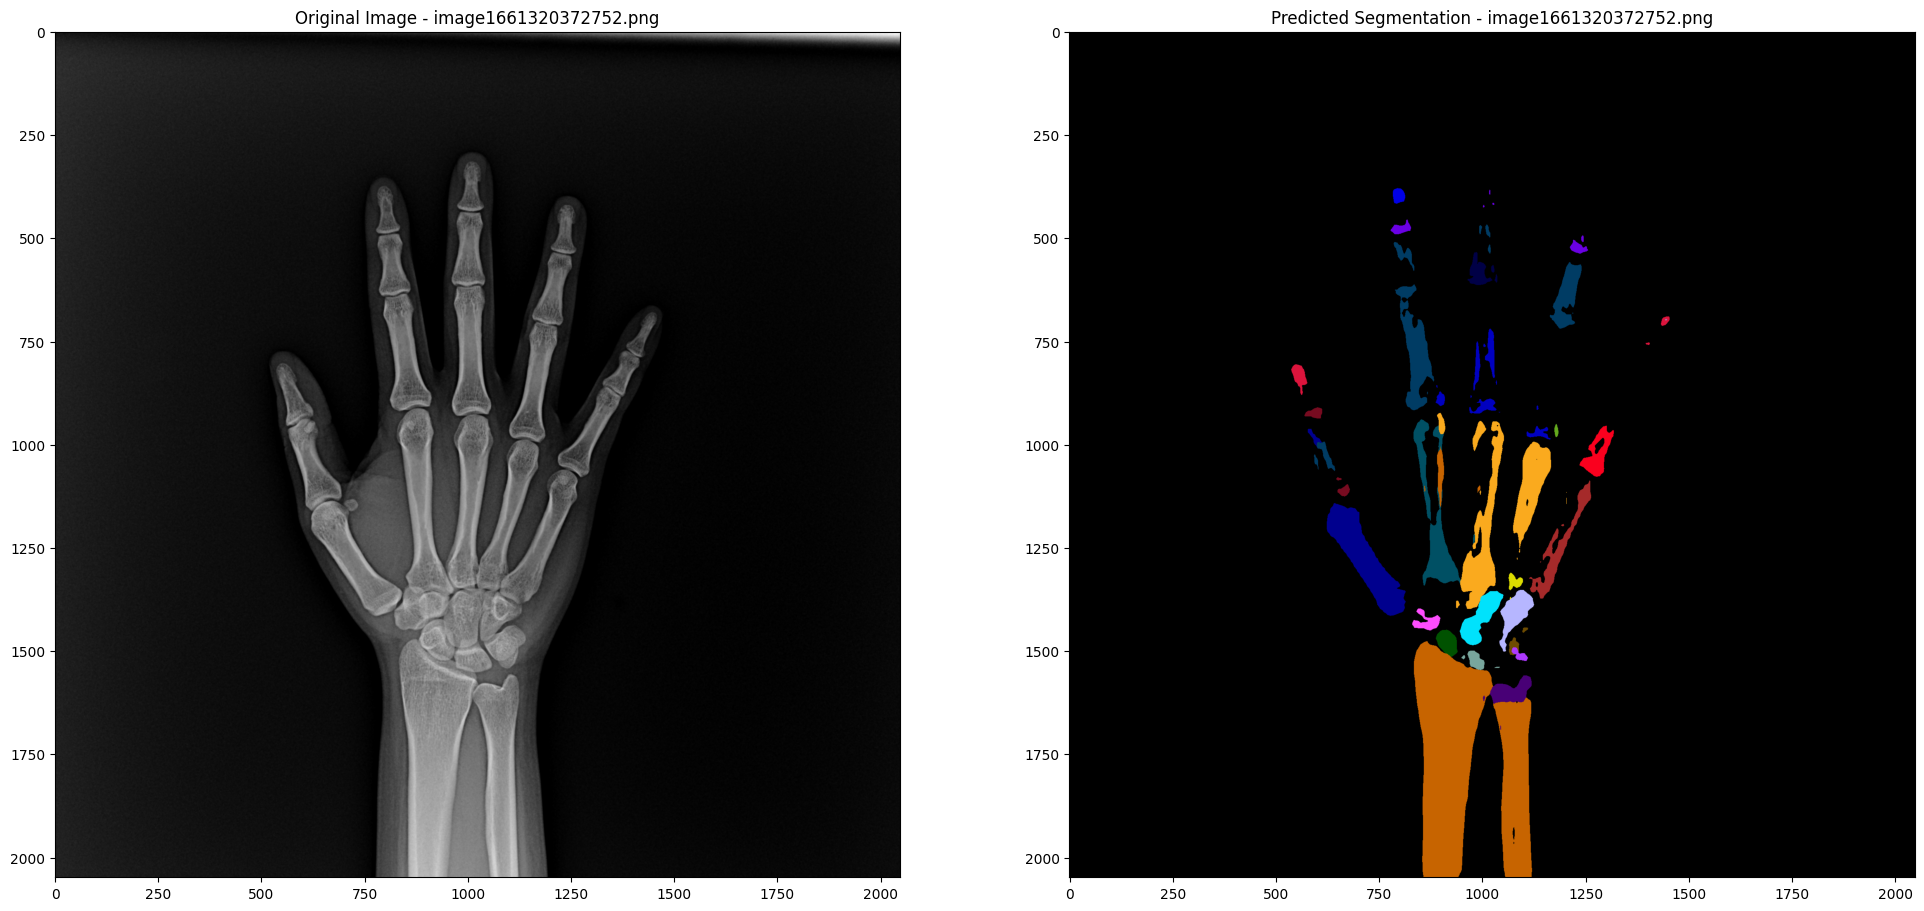

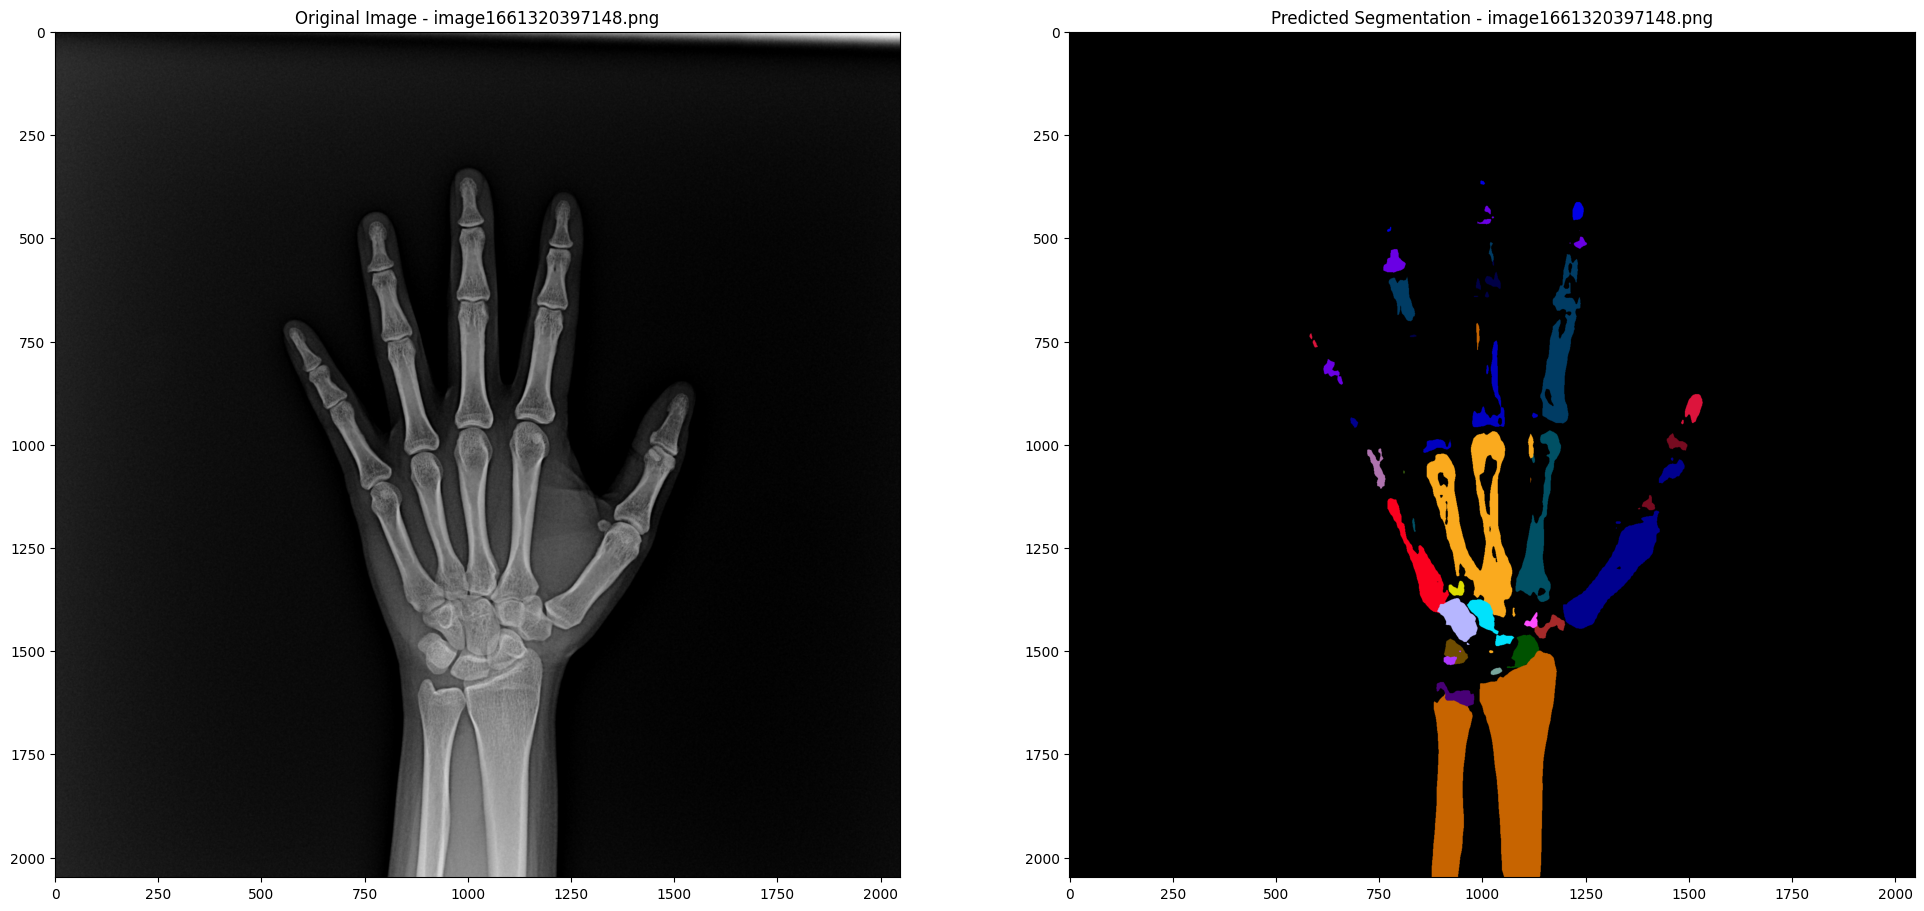

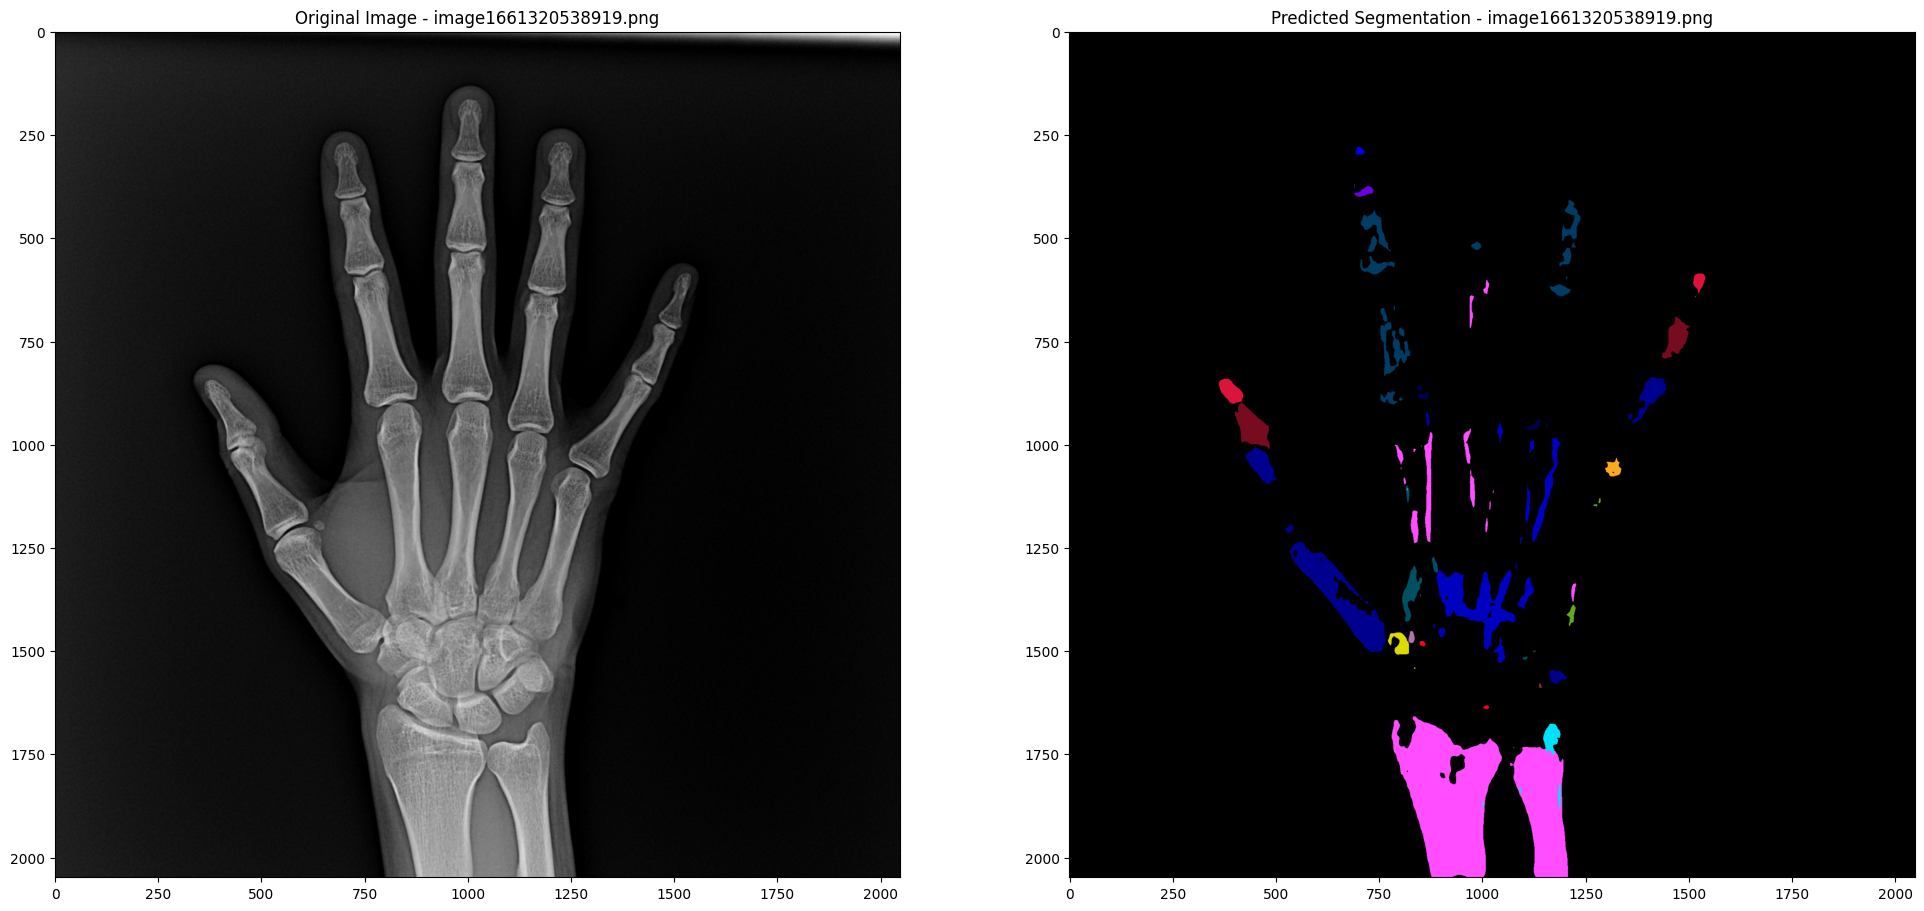

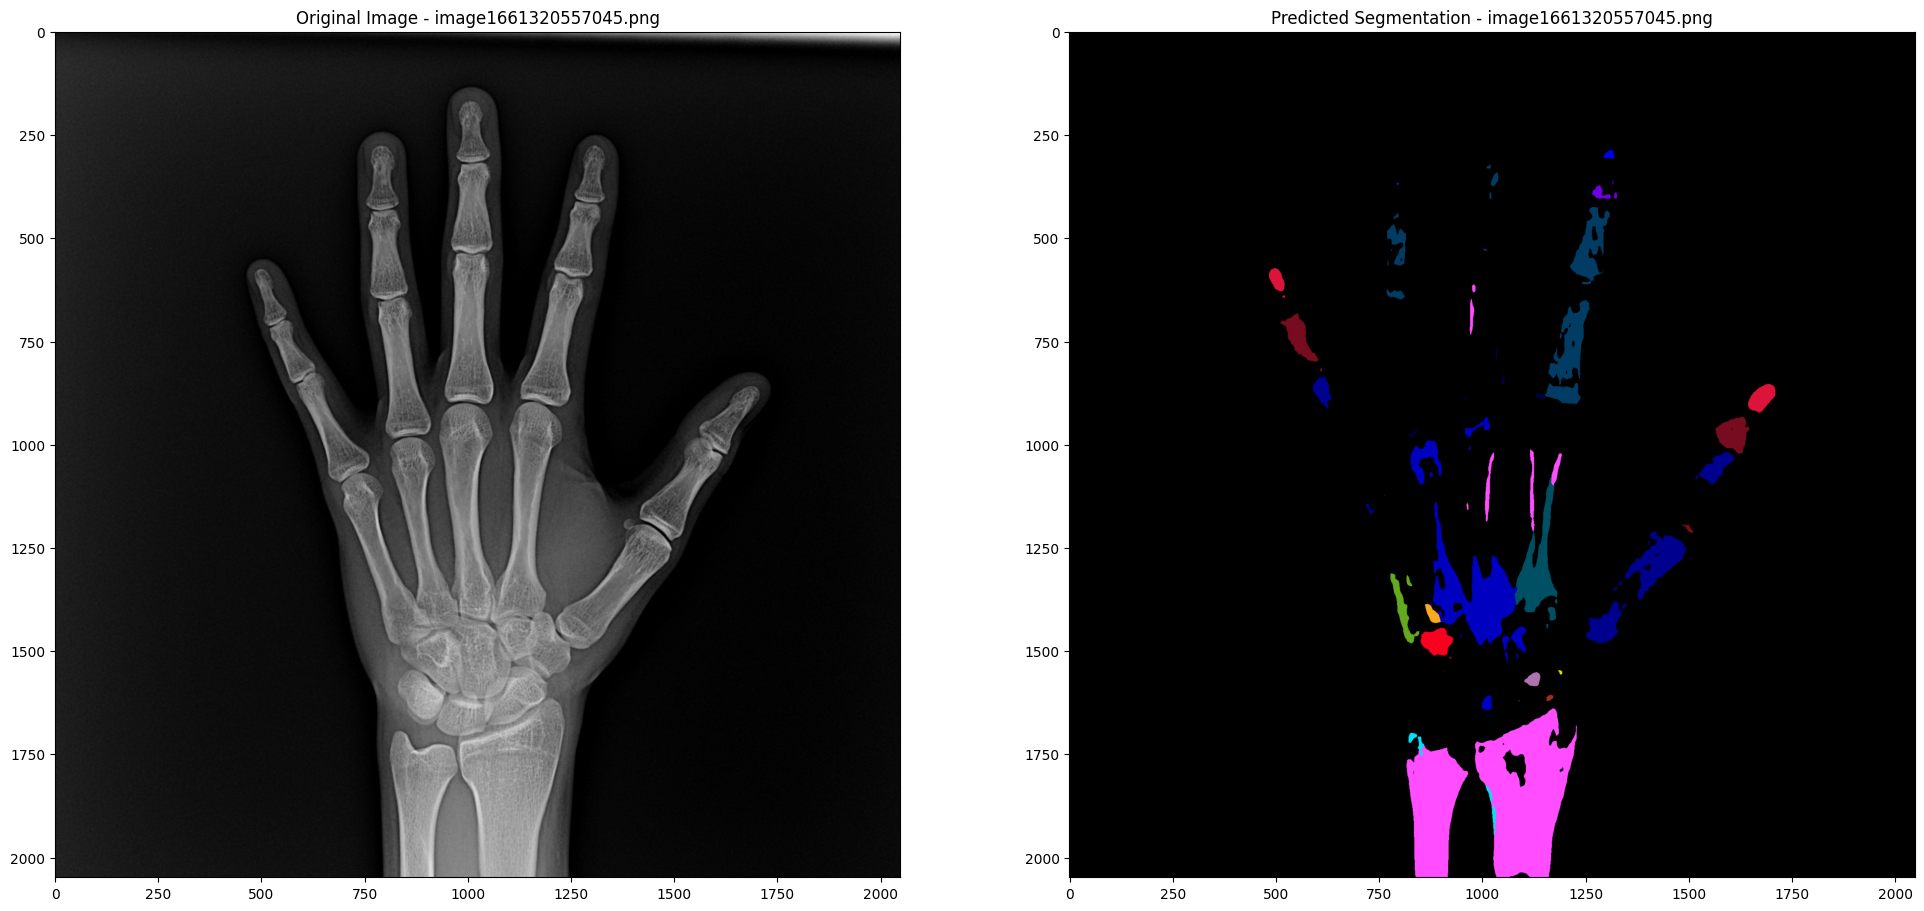

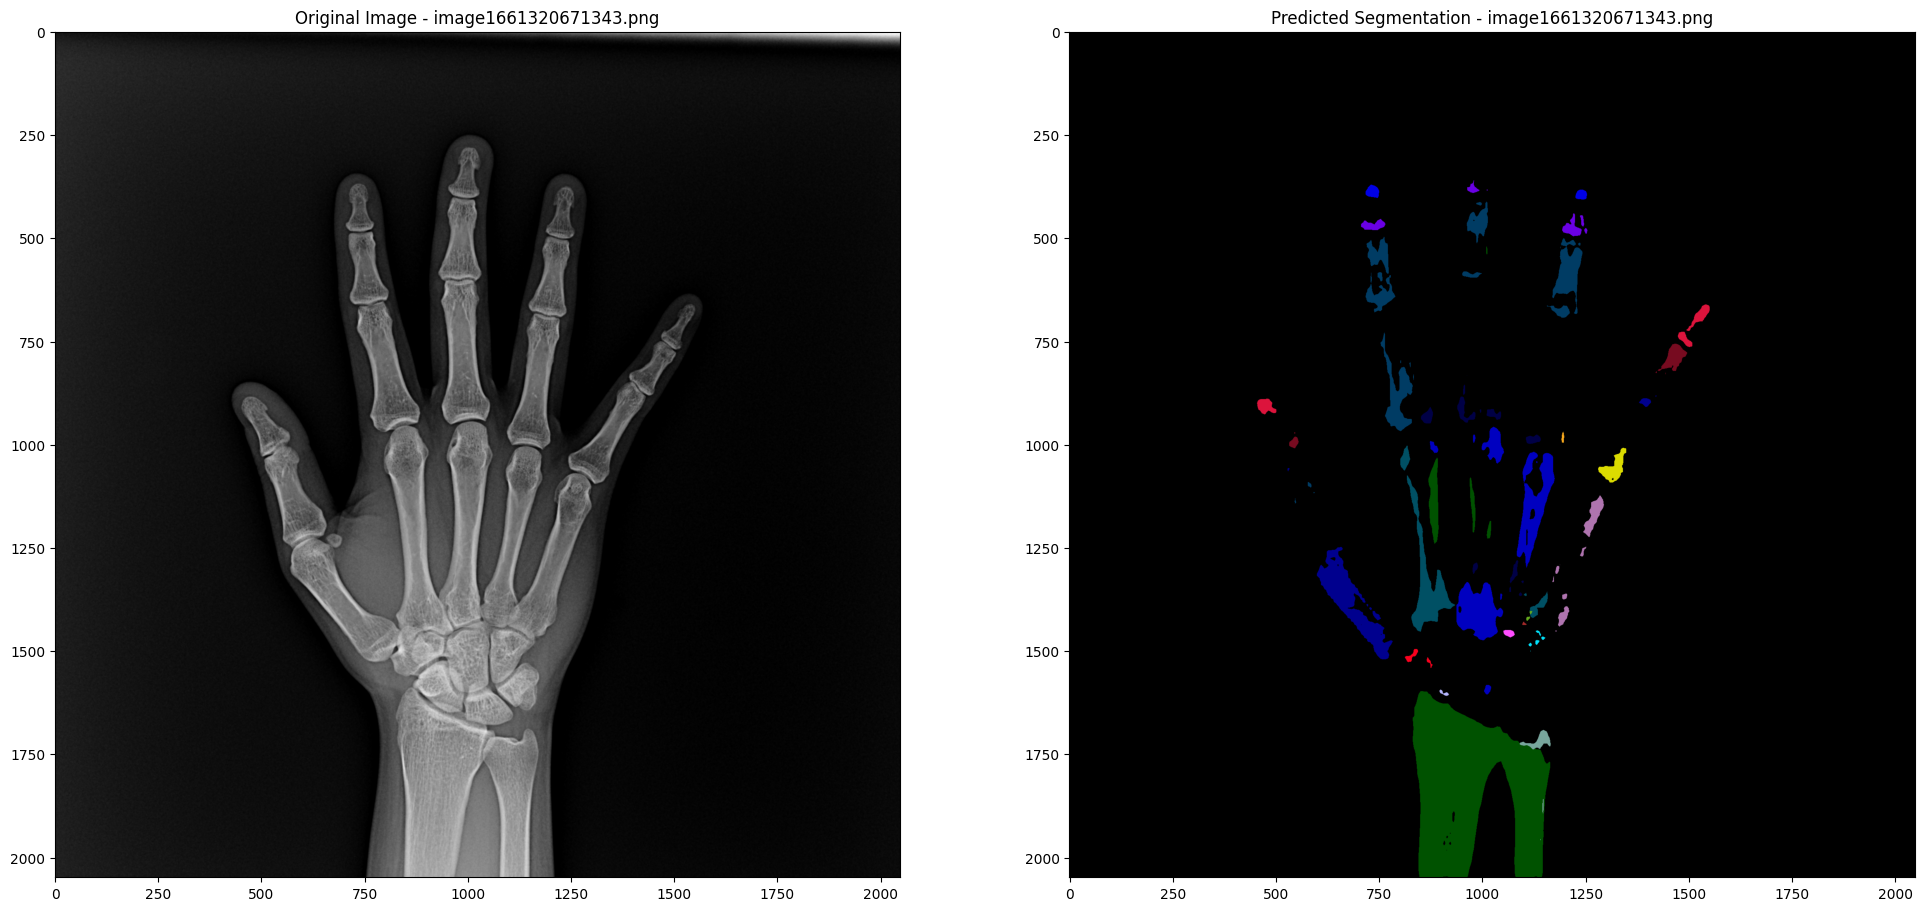

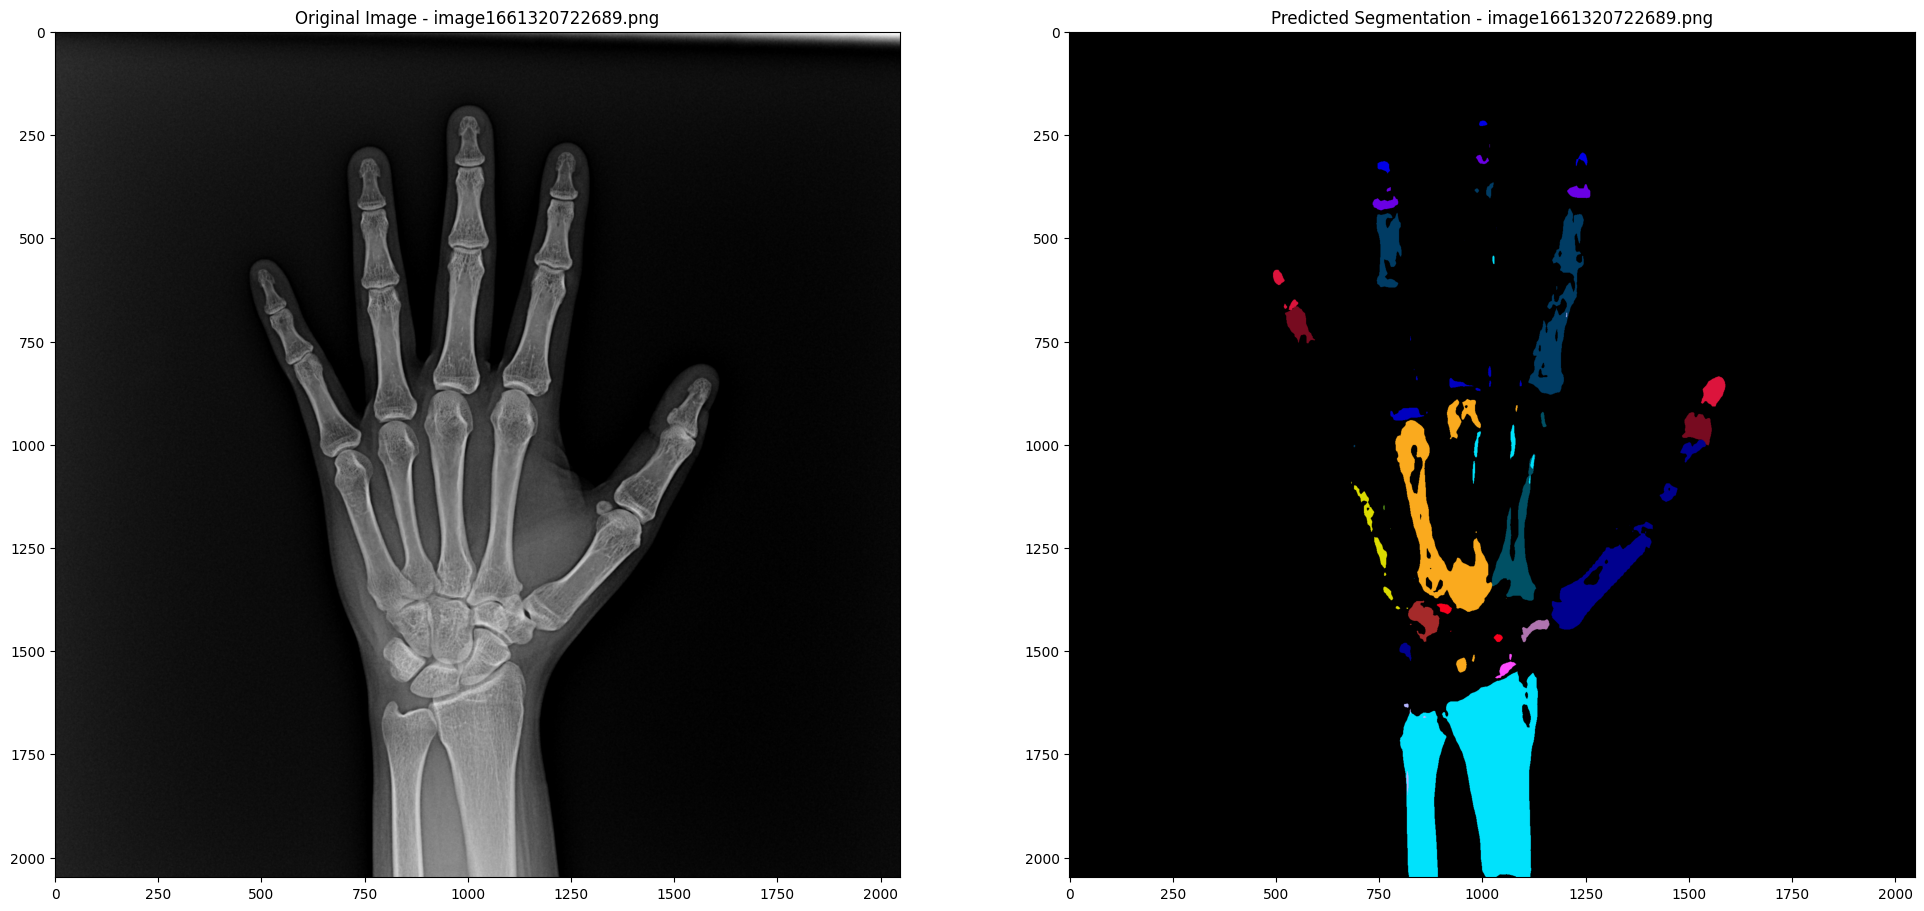

In [1]:
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
import os
import cv2
import matplotlib.pyplot as plt

config_path = '/data/ephemeral/home/level2-cv-semanticsegmentation-cv-22-lv3/configs/2024-11-21 18:21:46_FPN/FPN_epoch100.yaml'
csv_path = '/data/ephemeral/home/level2-cv-semanticsegmentation-cv-22-lv3/results/epoch_40_model_20241121_195522.csv'
start = 0
num = 10

PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

def load_from_csv(csv_path):
    # CSV 파일 읽기
    df = pd.read_csv(csv_path)
    
    # filename_and_class 복원
    filename_and_class = [f"{row['class']}_{row['image_name']}" for _, row in df.iterrows()]
    
    # rles 복원
    rles = df['rle'].tolist()
    
    return filename_and_class, rles

def find_image_path(folder, target_image_name):
    for root, dirs, files in os.walk(folder):
        if target_image_name in files:
            return os.path.join(root, target_image_name)
    return None

def do_visualization(cfg, csv_path):
    filename_and_class, rles = load_from_csv(csv_path)
    
    # 첫 30개의 파일에 대해 시각화 수행
    # 0 29 58
    for i in range(start, start + min(num, len(filename_and_class))):
        image_name = filename_and_class[i * len(cfg.data.classes)].split("_")[1]
        image_path = find_image_path(cfg.data.test_data_path, image_name)

        if not image_path:
            print(f"이미지를 찾을 수 없습니다: {image_name}")
            continue            

        image = cv2.imread(image_path)
        if image is None:
            print(f"이미지 파일을 로드할 수 없습니다: {image_path}")
            continue

        preds = []
        for rle in rles[i * len(cfg.data.classes): (i + 1) * len(cfg.data.classes)]:
            if isinstance(rle, str):
                pred = decode_rle_to_mask(rle, height=2048, width=2048)
                preds.append(pred)

        preds = np.stack(preds, 0)

        # BGR -> RGB 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(1, 2, figsize=(24, 12))
        ax[0].imshow(image)
        ax[0].set_title(f"Original Image - {image_name}")
        ax[1].imshow(label2rgb(preds))
        ax[1].set_title(f"Predicted Segmentation - {image_name}")

        plt.show()

if __name__ == "__main__":
    # cfg 파일 로드
    cfg = OmegaConf.load(config_path)
    
    # inference 실행
    do_visualization(cfg, csv_path)
